# This notebook will be dedicated to evaluating the results:

- Plotting confusion matrix, ROC curve, and feature importance

- Displaying performance metrics like precision, recall, etc.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier, Pool, EFstrType
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import shap

### Input eval-data

In [ ]:
X_eval_mi = np.load("../data/processed/X_eval_mi.npy")
eval_labels = np.load("../data/raw/eval_labels.npy")

### Select the best model in notebook-03

In [ ]:
model = CatBoostClassifier()
model.load_model("../models/best_catboost_model.cbm")

In [ ]:
preds = model.predict(X_eval_mi)
preds = preds.astype(int)

### Performance Metrics

#### Confusion Matrix

In [ ]:
f1 = f1_score(eval_labels, preds, average='macro')
print(f"F1 Score (macro): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(eval_labels, preds))

F1 Score (macro): 0.3267

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.85      0.67    635393
           1       0.28      0.09      0.14    249039
           2       0.31      0.12      0.18    290870

    accuracy                           0.51   1175302
   macro avg       0.38      0.35      0.33   1175302
weighted avg       0.43      0.51      0.43   1175302



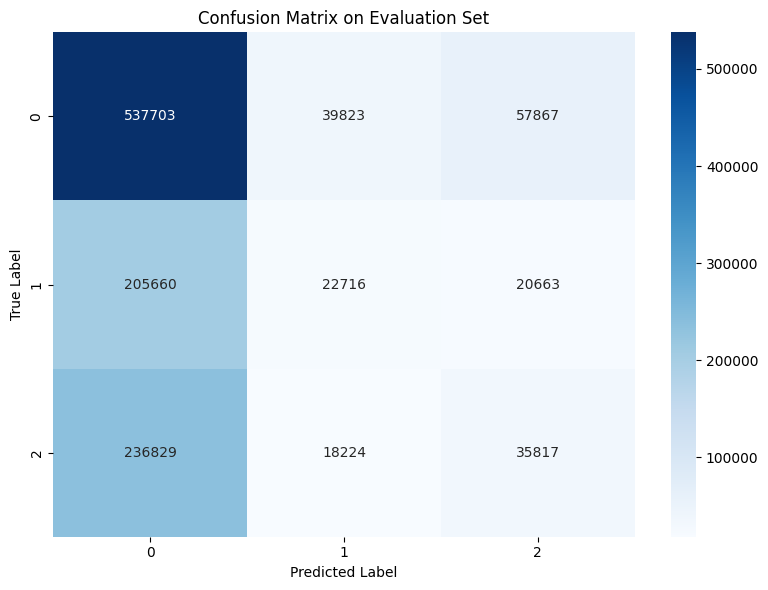

In [ ]:
cm = confusion_matrix(eval_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(eval_labels),
            yticklabels=np.unique(eval_labels))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Evaluation Set")
plt.tight_layout()
plt.show()

#### ROC Curve

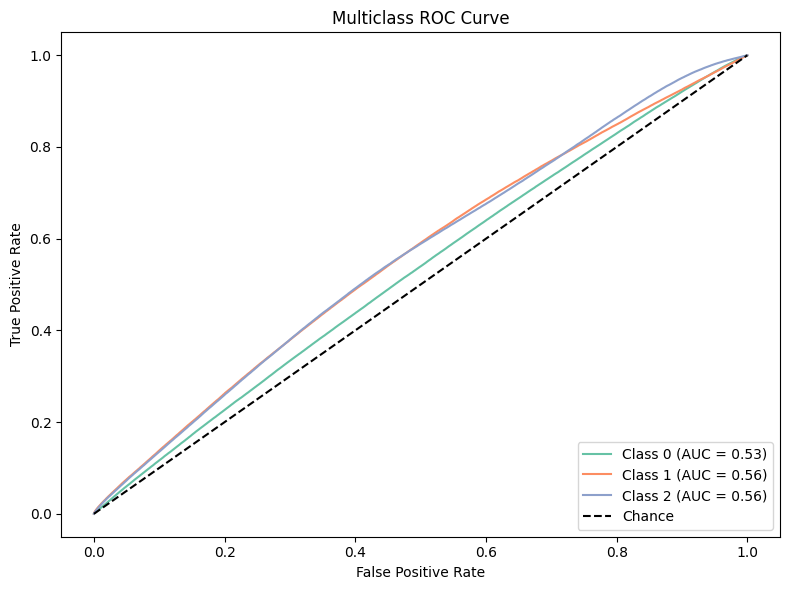

In [ ]:
probs = model.predict_proba(X_eval_mi)
y_bin = label_binarize(eval_labels, classes=np.unique(eval_labels))

fpr = {}
tpr = {}
roc_auc = {}
n_classes = probs.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

palette = sns.color_palette("Set2", n_colors=n_classes)

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})", color=palette[i])

plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### SHAP

In [ ]:
shap.initjs()

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_eval_mi)

In [ ]:
eval_pool = Pool(X_eval_mi)
shap_values = model.get_feature_importance(
    type=EFstrType.ShapValues,
    data=eval_pool,
    thread_count=-1
)

In [ ]:
shap_values = shap_values[:, :-1, :]
shap_values_transposed = shap_values.transpose((1, 0, 2))  # Shape: (n_classes, n_samples, n_features)
feature_names = [f"Feature_{i}" for i in range(X_eval_mi.shape[1])]

SHAP summary for class 0


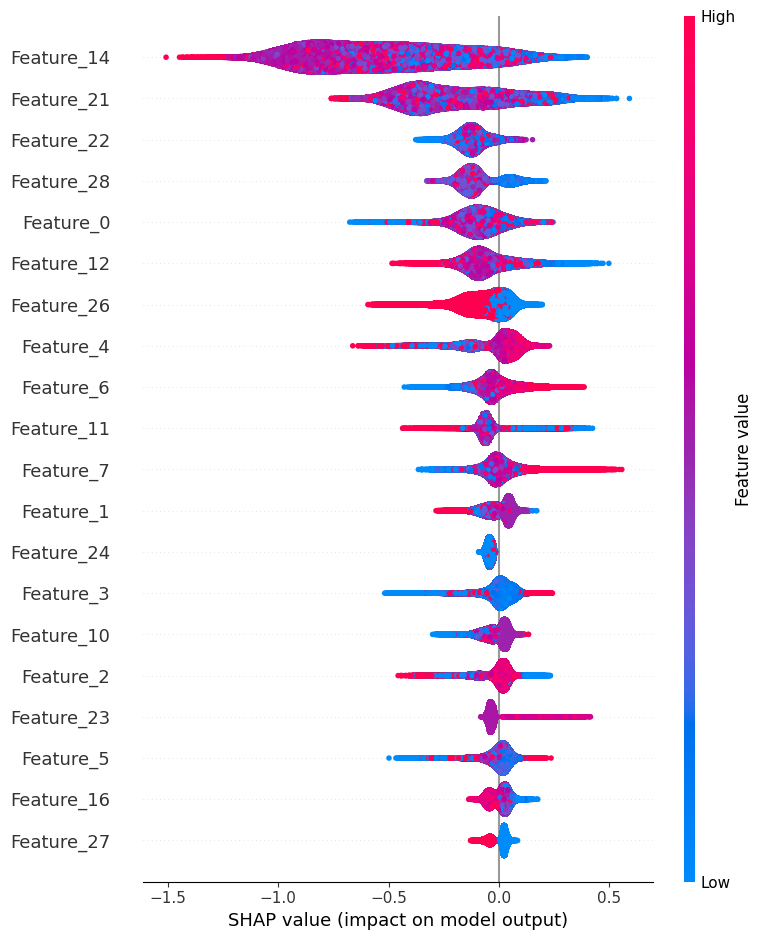

SHAP summary for class 1


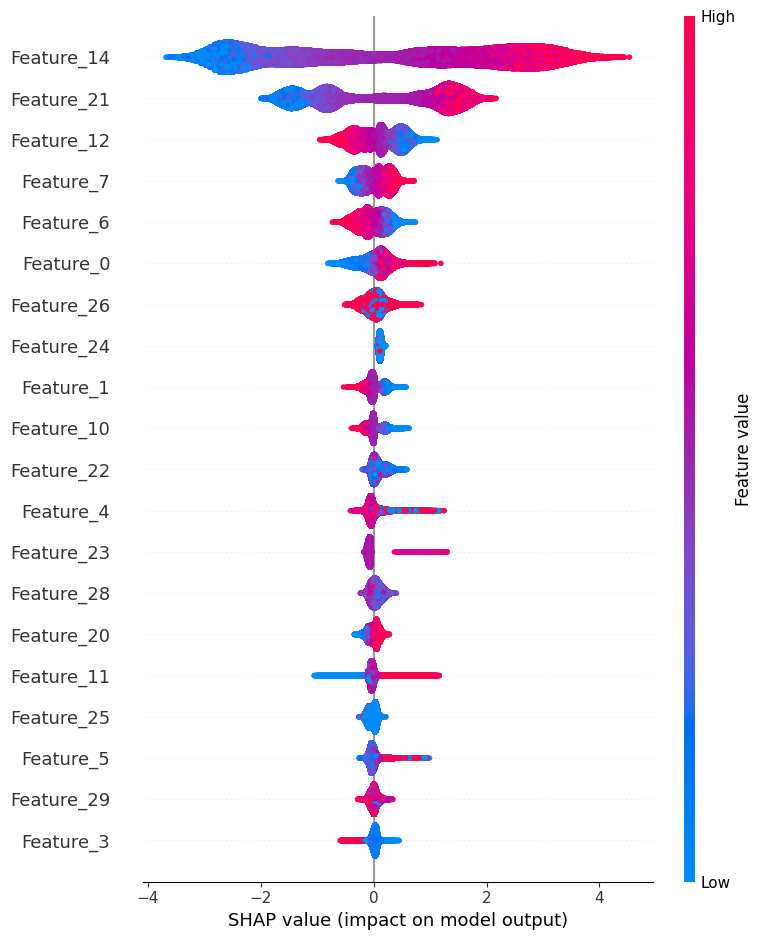

In [ ]:
for class_idx in range(shap_values_transposed.shape[0]):
    print(f"SHAP summary for class {class_idx}")
    
    # Remove the last column (expected value) before plotting
    shap_values_clean = shap_values_transposed[class_idx][:, :-1]
    
    shap.summary_plot(
        shap_values_clean,
        X_eval_mi,
        feature_names=feature_names,
        show=True
    )

In [ ]:
# Index you want to visualize
sample_idx = 1

# Check index 1 predict value
predicted_class = preds[1][0]
predicted_class

np.int64(0)

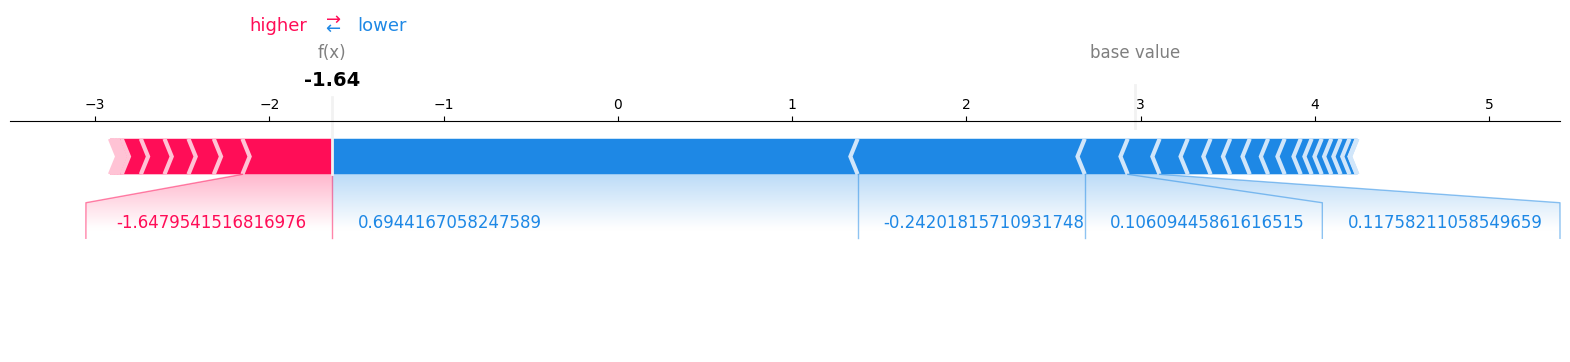

In [ ]:
shap.plots.force(
    explainer.expected_value[predicted_class],
    shap_values[predicted_class][sample_idx, :-1],
    X_eval_mi[sample_idx, :],
    matplotlib=True
)

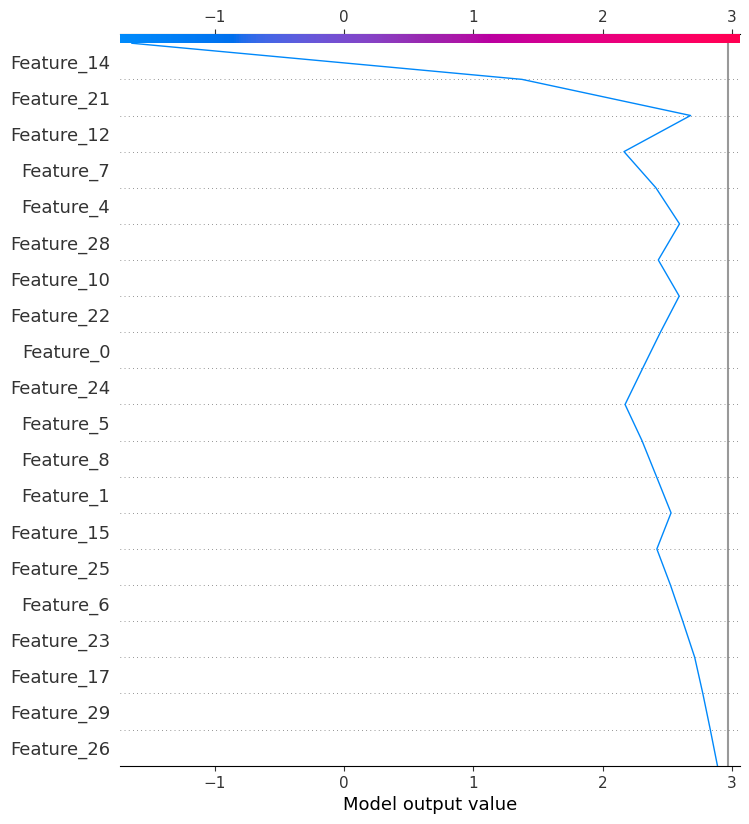

In [ ]:
# Draw decision plot
shap.decision_plot(
    explainer.expected_value[predicted_class],
    shap_values[predicted_class][sample_idx, :-1],
    feature_names=feature_names
)